In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf


price data for Nifty 50 Index

In [19]:
data = yf.download("^NSEI", start="2013-07-06", end="2023-07-06")
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-07-08,5833.149902,5833.850098,5775.549805,5811.549805,5811.549805,127600
2013-07-09,5834.600098,5864.950195,5834.600098,5859.000000,5859.000000,110400
2013-07-10,5869.899902,5879.350098,5802.850098,5816.700195,5816.700195,117500
2013-07-11,5894.500000,5948.850098,5887.950195,5935.100098,5935.100098,120200
2013-07-12,6000.500000,6019.000000,5951.149902,6009.000000,6009.000000,127700
...,...,...,...,...,...,...
2023-06-28,18908.150391,19011.250000,18861.349609,18972.099609,18972.099609,398800
2023-06-30,19076.849609,19201.699219,19024.599609,19189.050781,19189.050781,247900
2023-07-03,19246.500000,19345.099609,19234.400391,19322.550781,19322.550781,226100


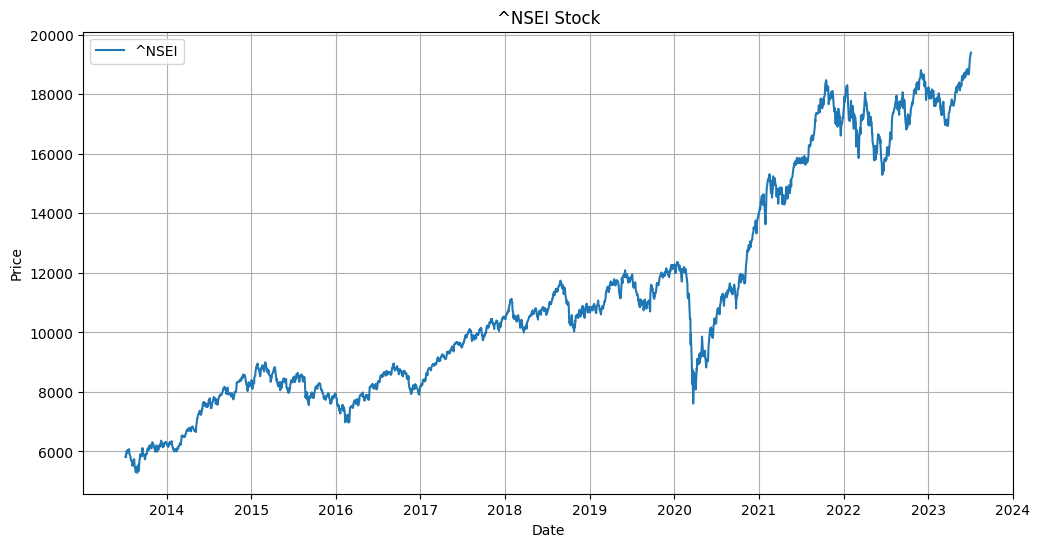

In [20]:
stock_symbols =['^NSEI']
for symbol in stock_symbols:
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Close'], label=symbol)
    plt.title(symbol + ' Stock')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

Keltner Channels

In [21]:
# Function to calculate Keltner Channels
def get_kc(high, low, close, kc_lookback, multiplier, a_lookback):
    a = pd.DataFrame(index=high.index)
    a['a1'] = high - low
    a['a2'] = abs(high - close.shift())
    a['a3'] = abs(low - close.shift())
    a['a'] = a.max(axis=1)
    
    aa = a['a'].ewm(alpha=1/a_lookback).mean()
    
    kc_middle = close.ewm(kc_lookback).mean()
    kc_upper = kc_middle + multiplier * aa
    kc_lower = kc_middle - multiplier * aa
    
    return kc_middle, kc_upper, kc_lower

In [22]:
# Generate Keltner Channels
data = data.iloc[:, :4]
data['kc_middle'], data['kc_upper'], data['kc_lower'] = get_kc(data['High'], data['Low'], data['Close'], 4, 2, 10)
data


,Open,High,Low,Close,kc_middle,kc_upper,kc_lower
Date,,,,,,,
2013-07-08,5833.149902,5833.850098,5775.549805,5811.549805,5811.549805,5928.150391,5694.949219
2013-07-09,5834.600098,5864.950195,5834.600098,5859.000000,5837.911024,5949.353818,5726.468230
2013-07-10,5869.899902,5879.350098,5802.850098,5816.700195,5829.218062,5955.995618,5702.440505
2013-07-11,5894.500000,5948.850098,5887.950195,5935.100098,5865.085960,6031.852539,5698.319381
2013-07-12,6000.500000,6019.000000,5951.149902,6009.000000,5907.897133,6074.916020,5740.878247
...,...,...,...,...,...,...,...
2023-06-28,18908.150391,19011.250000,18861.349609,18972.099609,18790.085698,19055.223993,18524.947403
2023-06-30,19076.849609,19201.699219,19024.599609,19189.050781,18869.878715,19154.423102,18585.334327
2023-07-03,19246.500000,19345.099609,19234.400391,19322.550781,18960.413128,19247.712843,18673.113414


In [23]:

# Function to generate buy/sell signals based on Keltner Channels
def method(prices, kc_upper, kc_lower):
    signals = np.zeros(len(prices))
    
    for i in range(1, len(prices)):
        if prices[i-1] < kc_lower[i-1] and prices[i] > kc_lower[i]:
            signals[i] = 1  # Buy signal
        elif prices[i-1] > kc_upper[i-1] and prices[i] < kc_upper[i]:
            signals[i] = -1  # Sell signal
    
    buy_price = np.where(signals == 1, prices, np.nan)
    sell_price = np.where(signals == -1, prices, np.nan)
    
    return buy_price, sell_price, signals

In [24]:

# Generate buy/sell signals using Keltner Channels
buy_price, sell_price, kc_signal = method(data['Close'], data['kc_upper'], data['kc_lower'])
data = data[:-1]

In [25]:
# Remove zero rows from buy/sell prices
buy_kc_df = pd.DataFrame(buy_price)
buy_kc_df = buy_kc_df.fillna(0)
buy_kc_df = buy_kc_df[~(buy_kc_df == 0).all(axis=1)]
sell_kc_df = pd.DataFrame(sell_price)
sell_kc_df = sell_kc_df.fillna(0)
sell_kc_df = sell_kc_df[~(sell_kc_df == 0).all(axis=1)]

In [26]:
# Ensure buy_kc and sell_kc have the same size
buy_kc = np.array(buy_kc_df)
buy_kc 


array([[ 5519.10009766],
       [ 8159.29980469],
       [ 7948.95019531],
       [ 7683.29980469],
       [ 7601.35009766],
       [ 6980.95019531],
       [ 9794.15039062],
       [ 9768.95019531],
       [10476.70019531],
       [10348.04980469],
       [11222.04980469],
       [11979.65039062],
       [11303.29980469],
       [ 9955.20019531],
       [ 8745.45019531],
       [ 7801.04980469],
       [11050.25      ],
       [17277.94921875],
       [16658.40039062],
       [15293.5       ],
       [17007.40039062],
       [18014.59960938]])

In [27]:
sell_kc = np.array(sell_kc_df)[:buy_kc.shape[0], :]
sell_kc

array([[ 5913.14990234],
       [ 6511.89990234],
       [ 7123.14990234],
       [ 8338.29980469],
       [ 8761.40039062],
       [ 8914.29980469],
       [ 8160.10009766],
       [ 8917.95019531],
       [ 8632.75      ],
       [ 9886.34960938],
       [11069.65039062],
       [11356.5       ],
       [11343.25      ],
       [11709.09960938],
       [11588.20019531],
       [12690.79980469],
       [12938.25      ],
       [16294.59960938],
       [17076.25      ],
       [17362.09960938],
       [18418.75      ],
       [17957.40039062]])

In [28]:
# Calculate evaluation metrics
cumulative_return = ((sell_kc - buy_kc) / buy_kc).max()
mean_return = np.mean(sell_kc - buy_kc)
std_deviation = np.std(sell_kc - buy_kc)
max_drawdown = (buy_kc - sell_kc).min() / sell_kc[18, 0]
sharpe_ratio = mean_return / std_deviation

In [29]:
# Print evaluation metrics
print("Cumulative return:", cumulative_return)
print("Mean return:", mean_return)
print("Standard Deviation:", std_deviation)
print("Max Drawdown:", max_drawdown)
print("Sharpe Ratio:", sharpe_ratio)

Cumulative return: 0.626806663516216
Mean return: 471.57266512784093
Standard Deviation: 1618.6355110005557
Max Drawdown: -0.2863479979503697
Sharpe Ratio: 0.29133962644643785


Descending triangle

In [30]:
# Function to check if a descending triangle pattern is present
def is_descending_triangle(data):
    highs = data['High']
    lows = data['Low']
    close = data['Close']

    if len(highs) < 4:
        return False

    if highs[0] >= highs[1] and lows[1] >= lows[2] and highs[3] >= highs[2]:
        if lows[0] <= lows[1] and close[0] > close[1]:
            return True

    return False

In [31]:
# Iterate over the stock symbols to identify descending triangles
marked_regions = {}

stock_symbols = ['^NSEI']  # Add your chosen Indian equity symbols here

for symbol in stock_symbols:
    marked_dates = []
    for i in range(len(data) - 3):
        data_subset = data.iloc[i:i+4]
        if is_descending_triangle(data_subset):
            marked_dates.append(data_subset.index[0])
    marked_regions[symbol] = marked_dates

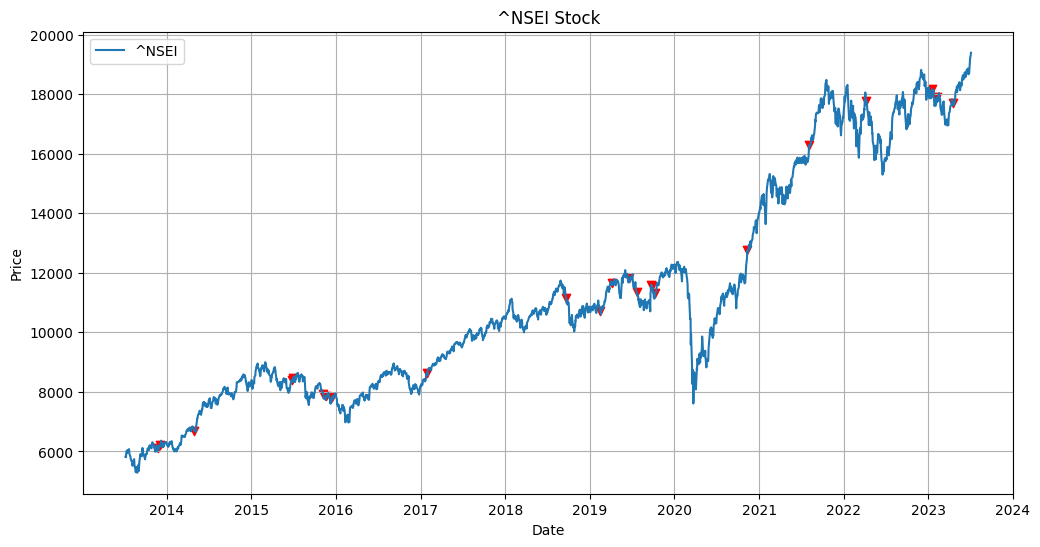

In [32]:

# Plot the stock graph with marked regions for descending triangles
for symbol in stock_symbols:
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Close'], label=symbol)
    for date in marked_regions[symbol]:
        plt.scatter(date, data.loc[date, 'Close'], marker='v', color='r')
    plt.title(symbol + ' Stock')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

In [33]:
for symbol in stock_symbols:
    if len(marked_regions[symbol]) > 0:
        print(f"Marked dates for {symbol}:")
        for date in marked_regions[symbol]:
            print(date)
        print("--------------------")

Marked dates for ^NSEI:
2013-11-25 00:00:00
2013-12-02 00:00:00
2014-04-30 00:00:00
2015-06-25 00:00:00
2015-07-01 00:00:00
2015-11-09 00:00:00
2015-11-20 00:00:00
2015-12-17 00:00:00
2017-01-27 00:00:00
2018-09-21 00:00:00
2019-02-15 00:00:00
2019-04-09 00:00:00
2019-06-20 00:00:00
2019-07-22 00:00:00
2019-09-23 00:00:00
2019-09-26 00:00:00
2019-10-09 00:00:00
2020-11-11 00:00:00
2021-08-05 00:00:00
2022-04-08 00:00:00
2023-01-18 00:00:00
2023-02-03 00:00:00
2023-02-09 00:00:00
2023-04-17 00:00:00
--------------------


Grid Search for parameter optimization

In [34]:
best_cumulative_return = -np.inf
best_max_drawdown = np.inf
best_sharpe_ratio = -np.inf
best_parameters = {}

# parameter ranges to explore
kc_lookback_range = range(2, 10)
multiplier_range = np.arange(1.5, 3.5, 0.5)
a_lookback_range = range(5, 20)

# Perform grid search for parameter optimization
for kc_lookback in kc_lookback_range:
    for multiplier in multiplier_range:
        for a_lookback in a_lookback_range:
            # Generate Keltner Channels with current parameter combination
            kc_middle, kc_upper, kc_lower = get_kc(data['High'], data['Low'], data['Close'],
                                       kc_lookback, multiplier, a_lookback)
            data.loc[:, 'kc_middle'] = kc_middle
            data.loc[:, 'kc_upper'] = kc_upper
            data.loc[:, 'kc_lower'] = kc_lower

            # Generate buy/sell signals using Keltner Channels
            buy_price, sell_price, kc_signal = method(data['Close'], data['kc_upper'], data['kc_lower'])
            data = data[:-1]
            # Remove zero rows from buy/sell prices
            buy_kc_df = pd.DataFrame(buy_price)
            buy_kc_df = buy_kc_df.fillna(0)
            buy_kc_df = buy_kc_df[~(buy_kc_df == 0).all(axis=1)]
            sell_kc_df = pd.DataFrame(sell_price)
            sell_kc_df = sell_kc_df.fillna(0)
            sell_kc_df = sell_kc_df[~(sell_kc_df == 0).all(axis=1)]
            # Ensure buy_kc and sell_kc have the same size
            buy_kc = np.array(buy_kc_df)
            sell_kc = np.array(sell_kc_df)

            # Calculate evaluation metrics
            if len(buy_kc) > 0 and len(sell_kc) > 0:
                min_length = min(len(buy_kc), len(sell_kc))
                cumulative_return = ((sell_kc[:min_length] - buy_kc[:min_length]) / buy_kc[:min_length]).max()
                mean_return = np.mean(sell_kc[:min_length] - buy_kc[:min_length])
                std_deviation = np.std(sell_kc[:min_length] - buy_kc[:min_length])
                max_drawdown = np.min((buy_kc[:min_length] - sell_kc[:min_length]) / sell_kc[:min_length])

                # Update the best metrics and parameters if improved
                if cumulative_return > best_cumulative_return and max_drawdown < best_max_drawdown and sharpe_ratio > best_sharpe_ratio:
                    best_cumulative_return = cumulative_return
                    best_max_drawdown = max_drawdown
                    best_sharpe_ratio = sharpe_ratio
                    best_parameters = {
                        'kc_lookback': kc_lookback,
                        'multiplier': multiplier,
                        'a_lookback': a_lookback
                    }

# Print best parameter combination and evaluation metrics
print("Best Parameters:")
print(best_parameters)
print("Best Cumulative Return:", best_cumulative_return)
print("Best Max Drawdown:", best_max_drawdown)
print("Best Sharpe Ratio:", best_sharpe_ratio)


Best Parameters:
{'kc_lookback': 2, 'multiplier': 1.5, 'a_lookback': 5}
Best Cumulative Return: 0.19240936516269933
Best Max Drawdown: -0.16136183661761652
Best Sharpe Ratio: 0.29133962644643785
